<a href="https://colab.research.google.com/github/Sunjung-Dev/AtoI-project/blob/main/window_size%2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_low = pd.read_csv(('/content/drive/My Drive/AtoI/005930.KS.csv'), header=0, names=['일자', '시가', '고가', '저가', '종가', '수정종가', '거래량'])
df_price = data_low

df_price.head()

,일자,시가,고가,저가,종가,수정종가,거래량
0,2020-02-20,60700.0,61300.0,59600.0,60000.0,57359.390625,14591924
1,2020-02-21,58800.0,59800.0,58500.0,59200.0,56594.593750,13777393
2,2020-02-24,57400.0,58100.0,56800.0,56800.0,54300.218750,25627537
3,2020-02-25,56200.0,58000.0,56200.0,57900.0,55351.808594,23885408
4,2020-02-26,56000.0,57000.0,56000.0,56500.0,54013.425781,25483102


In [4]:
pd.to_datetime(df_price['일자'], format='%Y-%m-%d')

df_price['일자'] = pd.to_datetime(df_price['일자'], format='%Y-%m-%d')
df_price['연도'] = df_price['일자'].dt.year
df_price['월'] = df_price['일자'].dt.month
df_price['일'] = df_price['일자'].dt.day

df = df_price.loc[df_price['일자']>="2020-02-19"]

df.head()

,일자,시가,고가,저가,종가,수정종가,거래량,연도,월,일
0,2020-02-20,60700.0,61300.0,59600.0,60000.0,57359.390625,14591924,2020,2,20
1,2020-02-21,58800.0,59800.0,58500.0,59200.0,56594.593750,13777393,2020,2,21
2,2020-02-24,57400.0,58100.0,56800.0,56800.0,54300.218750,25627537,2020,2,24
3,2020-02-25,56200.0,58000.0,56200.0,57900.0,55351.808594,23885408,2020,2,25
4,2020-02-26,56000.0,57000.0,56000.0,56500.0,54013.425781,25483102,2020,2,26


Text(0, 0.5, 'Price')

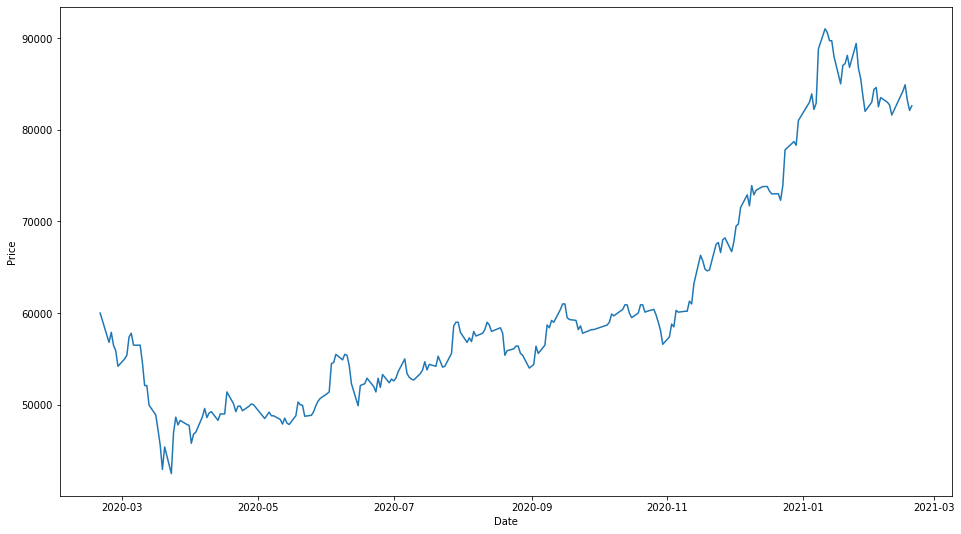

In [17]:
import seaborn as sns

plt.figure(figsize=(16, 9))
sns.lineplot(y=df['종가'], x=df['일자'])
plt.xlabel('Date')
plt.ylabel('Price')

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']

df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled.head()

,시가,고가,저가,종가,거래량
0,0.379455,0.333333,0.366525,0.360825,0.161583
1,0.339623,0.305164,0.343220,0.344330,0.152563
2,0.310273,0.273239,0.307203,0.294845,0.283785
3,0.285115,0.271362,0.294492,0.317526,0.264494
4,0.280922,0.252582,0.290254,0.288660,0.282186


In [7]:
TEST_SIZE = 100
window_size = 15

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [8]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [9]:
from sklearn.model_selection import train_test_split

feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, window_size)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((106, 15, 4), (27, 15, 4))

In [10]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((100, 4), (100, 1))

In [11]:
test_feature, test_label = make_dataset(test_feature, test_label, window_size)
test_feature.shape, test_label.shape

((85, 15, 4), (85, 1))

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(64, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1, activation='linear'))

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

import os
model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
7/7 [==============================] - 2s 93ms/step - loss: 0.0364 - val_loss: 0.0112

Epoch 00001: val_loss improved from inf to 0.01118, saving model to model/tmp_checkpoint.h5
Epoch 2/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0097 - val_loss: 0.0030

Epoch 00002: val_loss improved from 0.01118 to 0.00303, saving model to model/tmp_checkpoint.h5
Epoch 3/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0064 - val_loss: 0.0034

Epoch 00003: val_loss did not improve from 0.00303
Epoch 4/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0033 - val_loss: 0.0018

Epoch 00004: val_loss improved from 0.00303 to 0.00180, saving model to model/tmp_checkpoint.h5
Epoch 5/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0029 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00180
Epoch 6/200
7/7 [==============================] - 0s 30ms/step - loss: 0.0029 - val_loss: 0.0012

Epoch 00006: val_los

In [14]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

(85, 1)

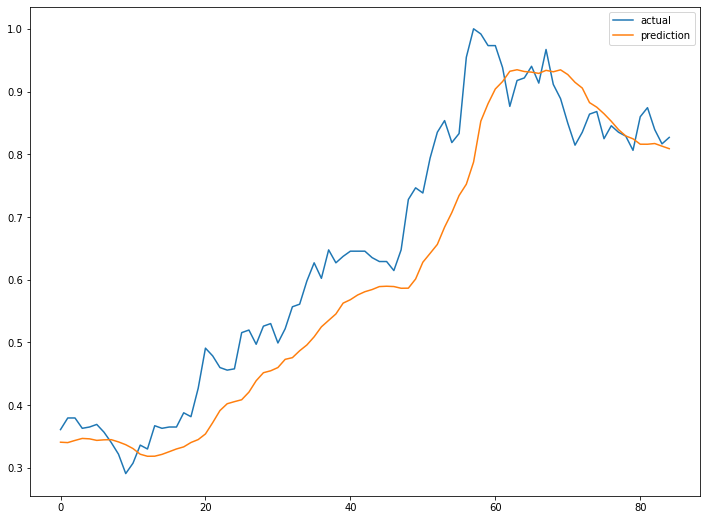

In [15]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()